In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("auge.csv", delimiter=",", encoding="utf-8")
df.head()

# What does "" means for Group?
df = df[df['Group'].notna() & (df['Group'].astype(str).str.strip() != '')]
df['NUMBER_OF_LYMPHNODES'] = pd.to_numeric(df['NUMBER_OF_LYMPHNODES'], errors='coerce')

threshold = 5

df['Group'] = df['NUMBER_OF_LYMPHNODES'].apply(
    lambda n: 'Picking' if n <= threshold else 'TLND'
)

# Convert AGE and other numeric columns with potential issues
df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')
df['OP_DATE'] = pd.to_datetime(df['OP_DATE'], errors='coerce', dayfirst=True)
df['DATE_OF_DEATH'] = pd.to_datetime(df['DATE_OF_DEATH'], errors='coerce', dayfirst=True)
df['Group'] = df['Group'].astype('category')

df = df[df['NUMBER_OF_LYMPHNODES'] != -99]


/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_47127/3214256901.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE_OF_DEATH'] = pd.to_datetime(df['DATE_OF_DEATH'], errors='coerce', dayfirst=True)


In [2]:
avg_nodes = (
    df.groupby('Group')['NUMBER_OF_LYMPHNODES']
    .mean()
    .reset_index(name='Average_NUMBER_OF_LYMPHNODES')
)

print(avg_nodes)

     Group  Average_NUMBER_OF_LYMPHNODES
0  Picking                      2.387097
1     TLND                     16.281553


/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_47127/3267038640.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Group')['NUMBER_OF_LYMPHNODES']


/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_47127/674349423.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_stats = df.groupby('Group')['AGE'].describe()
/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_47127/674349423.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='AGE', data=df, palette='Set2')


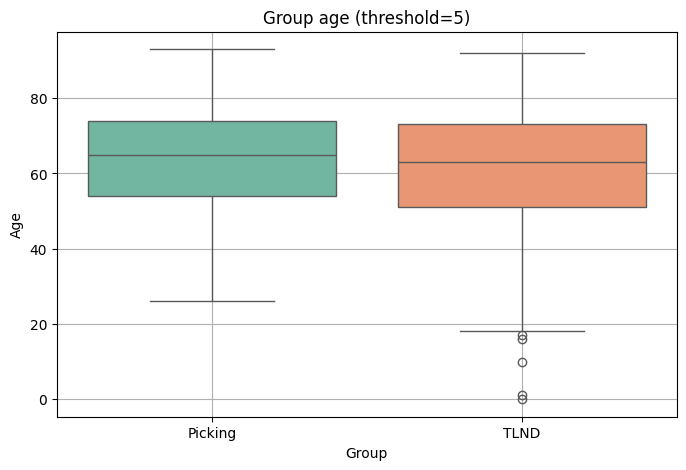

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

age_stats = df.groupby('Group')['AGE'].describe()

plt.figure(figsize=(8, 5))
sns.boxplot(x='Group', y='AGE', data=df, palette='Set2')
plt.title(f'Group age (threshold={threshold})')
plt.xlabel('Group')
plt.ylabel('Age')
plt.grid(True)
plt.show()


/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_47127/2126529202.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Group')['MUTATION']


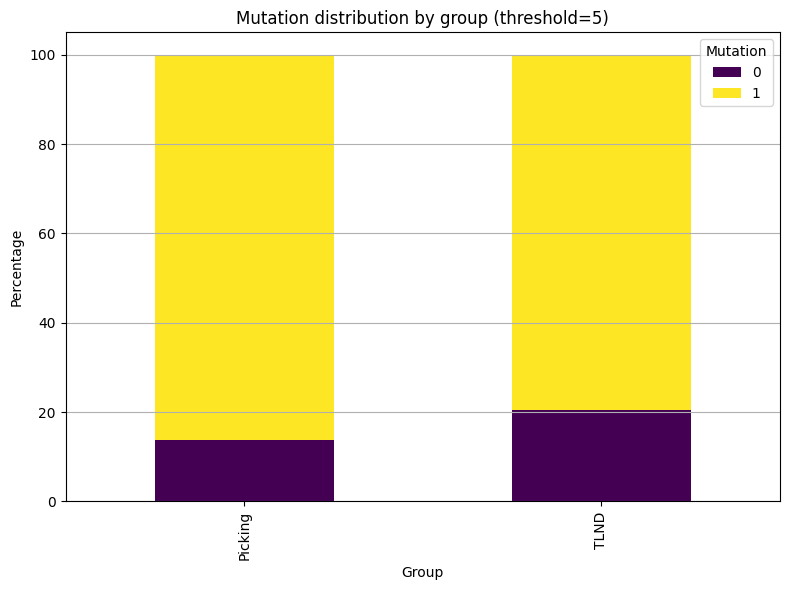

In [4]:
filtered_df = df[df['MUTATION'] != -99]

# Calculate mutation rate per group
mutation_rate = (
    filtered_df
    .groupby('Group')['MUTATION']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0) * 100
)

# Plot
mutation_rate.plot(kind='bar', stacked=True, colormap='viridis', figsize=(8, 6))
plt.title(f'Mutation distribution by group (threshold={threshold})')
plt.ylabel('Percentage')
plt.xlabel('Group')
plt.legend(title='Mutation', loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

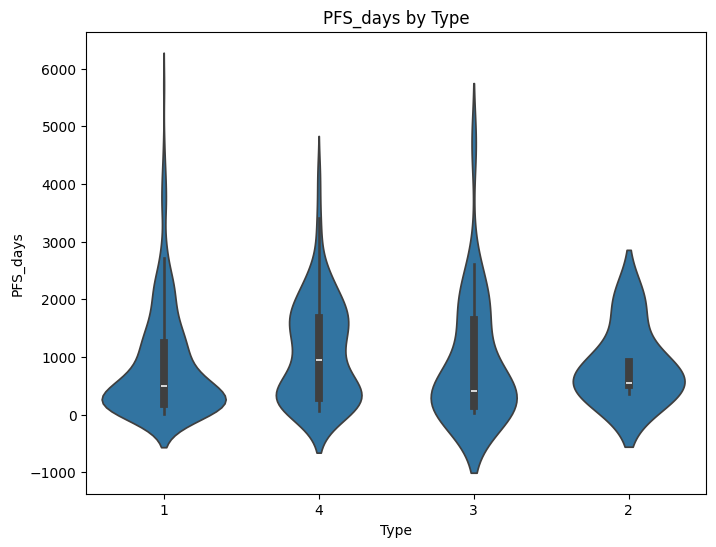

In [5]:
# Wie wirkt sich der Type (Melanomtyp) (Spalte 21 im SPSS Datensatz) auf das PFS
# aus der jeweiligen Gruppen (haben zum Beispiel Patienten mit einem Cutanen
# Melanom ein geringeres PFS?)

# Remove rows where PFS_days or type is -99
df = df[(df['PFS_days'] != -99) & (df['Type'] != -99)]

# If type is categorical, ensure it's treated that way
df['Type'] = df['Type'].astype(str)

# Plot: Boxplot to see distribution of PFS_days per type
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x='Type', y='PFS_days', inner='box')
plt.title('PFS_days by Type')
plt.xlabel('Type')
plt.ylabel('PFS_days')
plt.show()


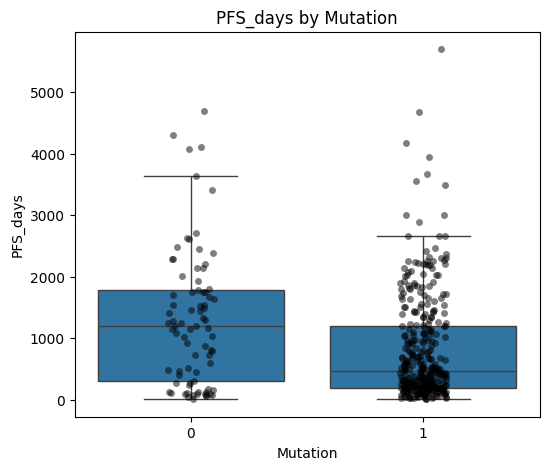

In [6]:
# Wie wirkt sich Mutation (JA/NEIN Frage) (Spalte 31 im SPSS Datensatz) auf das PFS
# der jeweiligen Gruppen aus (haben zum Beispiel Patienten mit einer Mutation ein
# geringeres PFS?)

# Remove rows where PFS_days or type is -99
df = df[(df['PFS_days'] != -99) & (df['MUTATION'] != -99)]

plt.figure(figsize=(6, 5))
sns.boxplot(data=df, x='MUTATION', y='PFS_days', showfliers=False)
sns.stripplot(data=df, x='MUTATION', y='PFS_days', color='black', alpha=0.5, jitter=True)
plt.title('PFS_days by Mutation')
plt.xlabel('Mutation')
plt.ylabel('PFS_days')
plt.show()


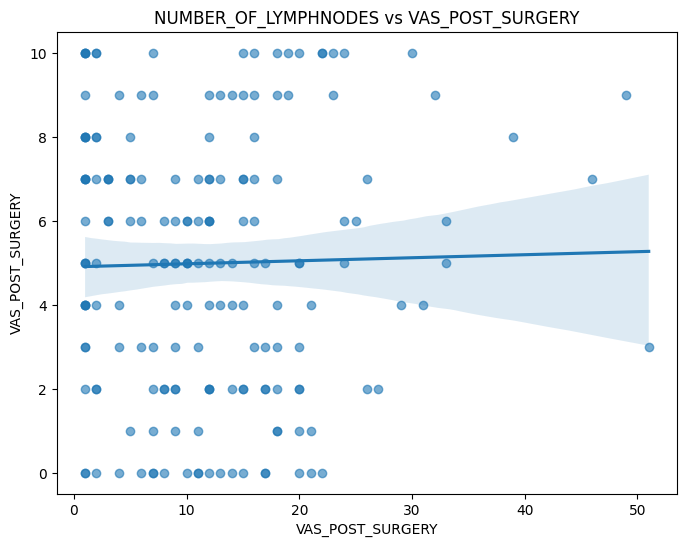

In [7]:
# Kann man schauen ob: je höher die Anzahl der entnommenen Lymphknoten desto
# höher die post surgery complications? Es gibt zb. Patienten bei denen 50
# Lymphknoten entnommen werden

df = df[(df['NUMBER_OF_LYMPHNODES'] != -99) & (df['VAS_POST_SURGERY'] != -99)]

df['VAS_POST_SURGERY'] = pd.to_numeric(df['VAS_POST_SURGERY'], errors='coerce')

# Remove NaNs created by coercion
df = df.dropna(subset=['NUMBER_OF_LYMPHNODES', 'VAS_POST_SURGERY'])

plt.figure(figsize=(8, 6))
sns.regplot(
    data=df, 
    x='NUMBER_OF_LYMPHNODES', 
    y='VAS_POST_SURGERY', 
    scatter_kws={'alpha':0.6}
)
plt.title('NUMBER_OF_LYMPHNODES vs VAS_POST_SURGERY')
plt.xlabel('VAS_POST_SURGERY')
plt.ylabel('VAS_POST_SURGERY')
plt.show()

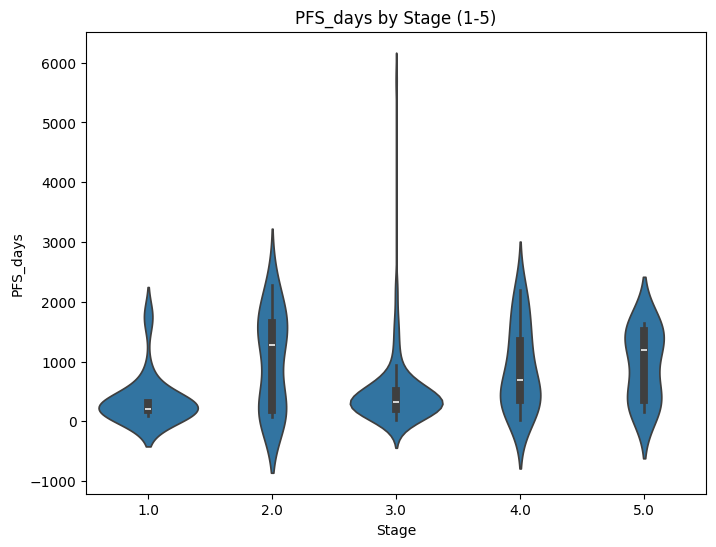

In [8]:
# Remove invalid values in PFS_days and STAGE
df = df[(df['PFS_days'] != -99) & (df['STAGE'] != -99)]
df = df.dropna(subset=['STAGE'])

# Convert STAGE to numeric to filter valid range
df['STAGE'] = pd.to_numeric(df['STAGE'], errors='coerce')

# Keep only stages 1 to 5
df = df[df['STAGE'].between(1, 5)]

# Plot violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x='STAGE', y='PFS_days', inner='box')
plt.title('PFS_days by Stage (1-5)')
plt.xlabel('Stage')
plt.ylabel('PFS_days')
plt.show()


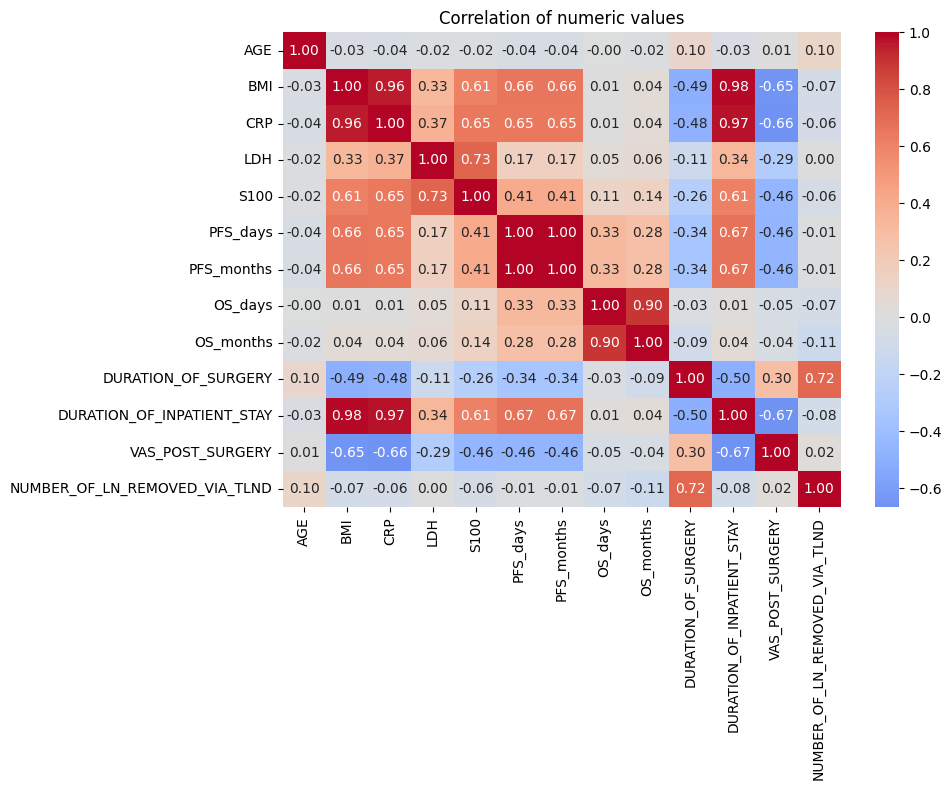

In [9]:
# Select numeric cols
numerical_cols = [
    'AGE', 'BMI', 'CRP', 'LDH', 'S100', 'PFS_days', 'PFS_months',
    'OS_days', 'OS_months', 'DURATION_OF_SURGERY', 'DURATION_OF_INPATIENT_STAY',
    'VAS_POST_SURGERY', 'NUMBER_OF_LN_REMOVED_VIA_TLND'
]

# Choose only valid lines
corr_df = df[numerical_cols].copy()
corr_df = corr_df.apply(pd.to_numeric, errors='coerce')
corr_df.dropna(how='any', inplace=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation of numeric values")
plt.tight_layout()
plt.show()



/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_47127/2823430858.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=valid_os, x='Group', y='OS_months', palette='Set3', inner='box')


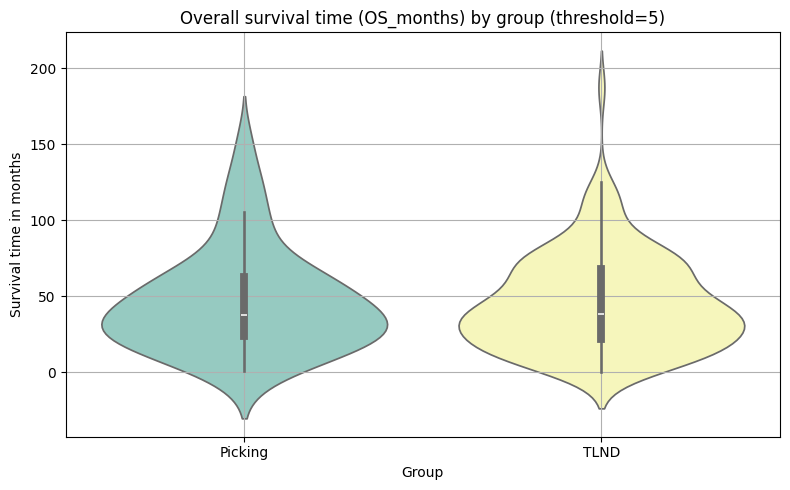

In [10]:
# Filter for valid OS values
valid_os = df[
    (df['OS_months'] != -99) &
    df['OS_months'].notna() &
    df['Group'].notna()
]

# Plot violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(data=valid_os, x='Group', y='OS_months', palette='Set3', inner='box')
plt.title(f'Overall survival time (OS_months) by group (threshold={threshold})')
plt.xlabel('Group')
plt.ylabel('Survival time in months')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_47127/3130923394.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='MUTATION', y='BMI', ax=axes[0], palette='pastel')
/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_47127/3130923394.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='MUTATION', y='CRP', ax=axes[1], palette='pastel')


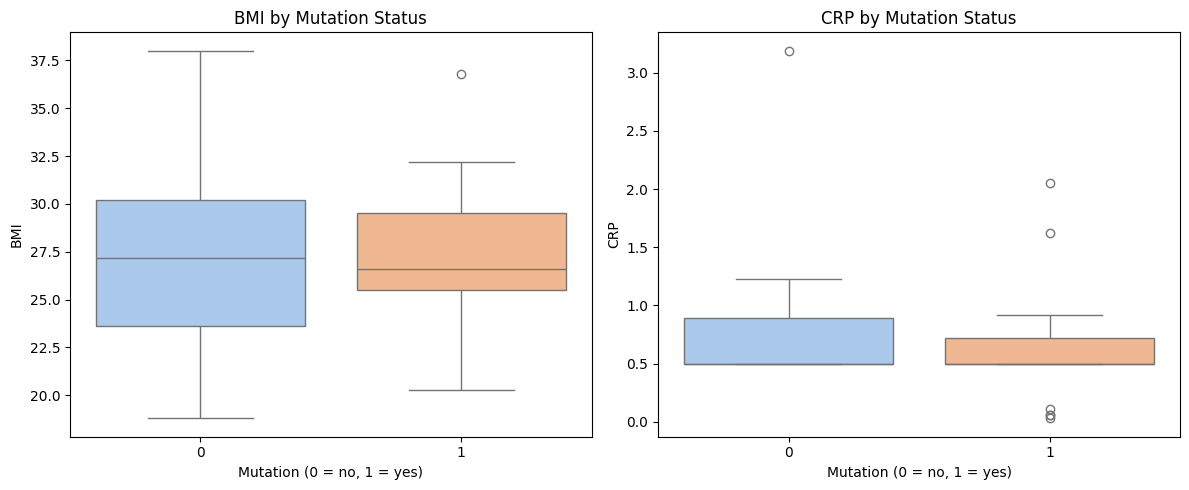

In [11]:
# Filter MUTATION to 0 and 1
subset = df[df['MUTATION'].isin([0, 1])]

# Filter out invalid values (-99) from BMI and CRP
subset = subset[(subset['BMI'] != -99) & (subset['CRP'] != -99)]

# Drop any NaNs
subset = subset[['MUTATION', 'BMI', 'CRP']].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=subset, x='MUTATION', y='BMI', ax=axes[0], palette='pastel')
axes[0].set_title('BMI by Mutation Status')
axes[0].set_xlabel('Mutation (0 = no, 1 = yes)')

sns.boxplot(data=subset, x='MUTATION', y='CRP', ax=axes[1], palette='pastel')
axes[1].set_title('CRP by Mutation Status')
axes[1].set_xlabel('Mutation (0 = no, 1 = yes)')

plt.tight_layout()
plt.show()


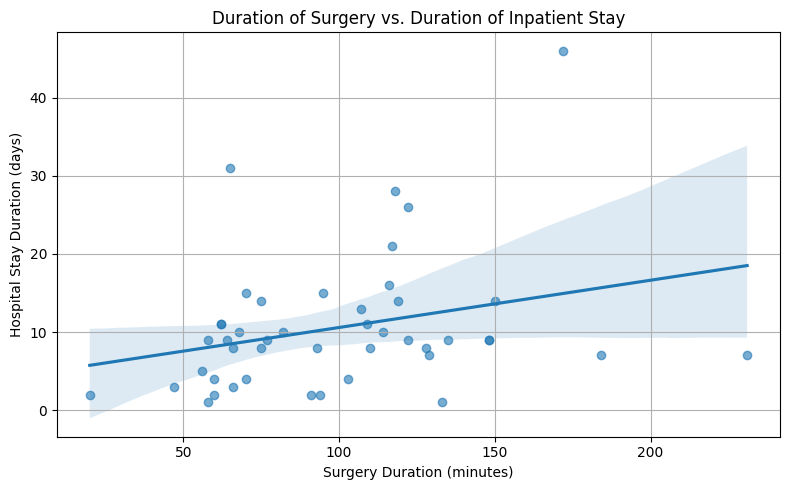

In [12]:
subset = df[
    (df['DURATION_OF_SURGERY'] != -99) &
    (df['DURATION_OF_INPATIENT_STAY'] != -99) &
    df['DURATION_OF_SURGERY'].notna() &
    df['DURATION_OF_INPATIENT_STAY'].notna()
][['DURATION_OF_SURGERY', 'DURATION_OF_INPATIENT_STAY']]

plt.figure(figsize=(8, 5))
sns.regplot(data=subset, x='DURATION_OF_SURGERY', y='DURATION_OF_INPATIENT_STAY', scatter_kws={'alpha': 0.6})
plt.title("Duration of Surgery vs. Duration of Inpatient Stay")
plt.xlabel("Surgery Duration (minutes)")
plt.ylabel("Hospital Stay Duration (days)")
plt.grid(True)
plt.tight_layout()
plt.show()


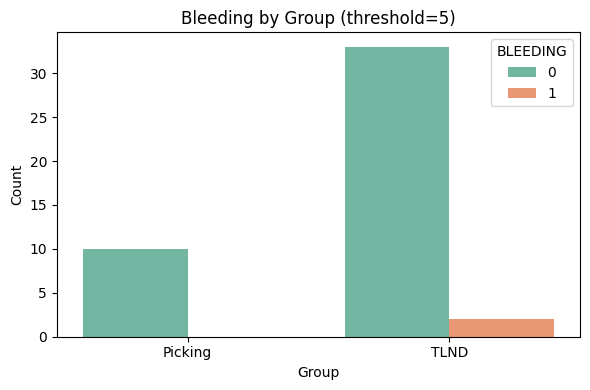

In [13]:
# Filter out invalid BLEEDING values
filtered_df = df[df['BLEEDING'] != -99]

# Barplot of Bleeding by Group
plt.figure(figsize=(6, 4))
sns.countplot(data=filtered_df, x='Group', hue='BLEEDING', palette='Set2')
plt.title(f"Bleeding by Group (threshold={threshold})")
plt.xlabel("Group")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

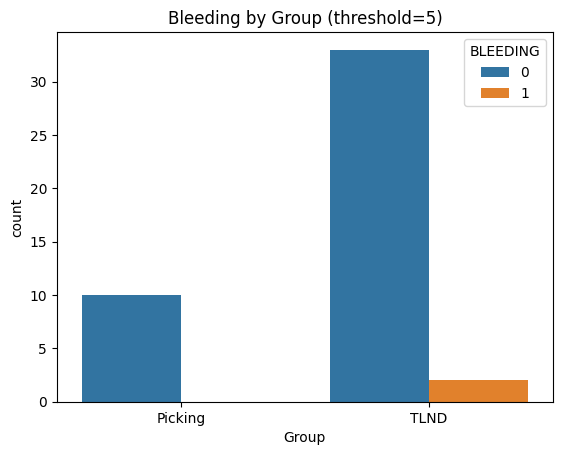

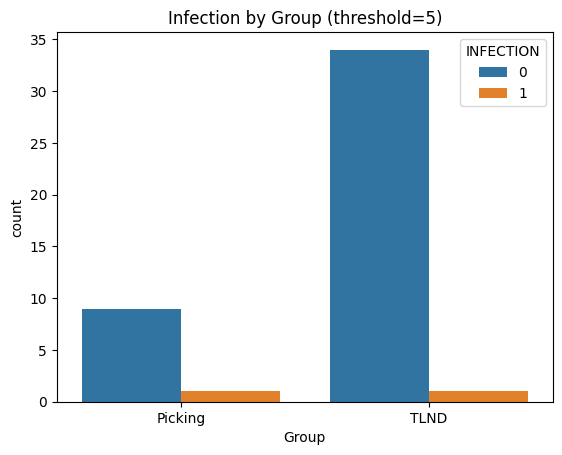

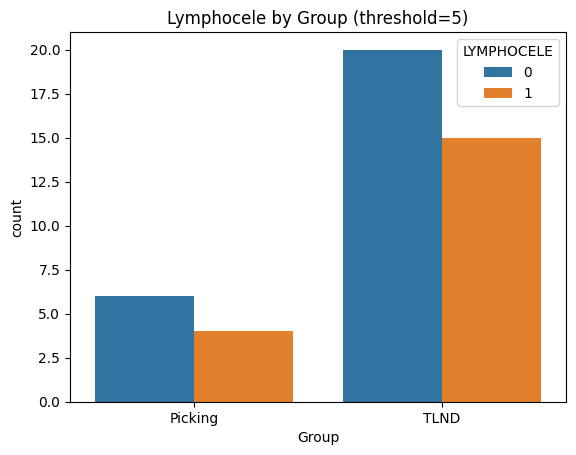

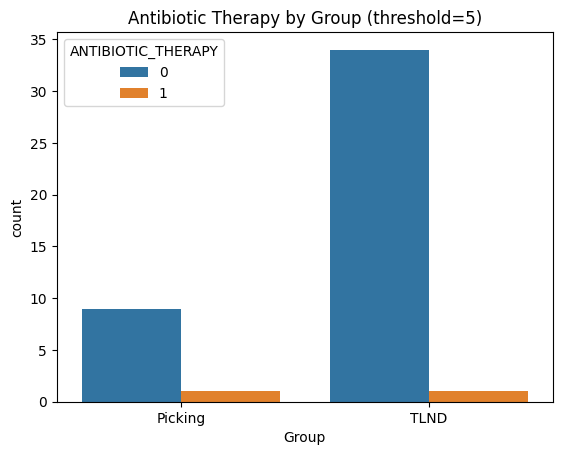

In [14]:
complications = ['BLEEDING', 'INFECTION', 'LYMPHOCELE', 'ANTIBIOTIC_THERAPY']

for comp in complications:
    filtered_df = df[
        (df['BLEEDING'] != -99) &
        (df['ANTIBIOTIC_THERAPY'] != -99)
    ]
    
    sns.countplot(data=filtered_df, x='Group', hue=comp)
    plt.title(f"{comp.replace('_', ' ').title()} by Group (threshold={threshold})")
    plt.show()
